In [1]:
import pandas as pd
import numpy as np
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy import distance
from geopy.extra.rate_limiter import RateLimiter
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
properties_df = pd.read_csv("properties-susquehannavalley.csv",index_col=0)

In [73]:
properties_df = properties_df[properties_df['list-card-type']!="Lot / Land for sale"]
properties_df = properties_df[properties_df['list-card-type']!="New construction"]
properties_df = properties_df[properties_df['list-card-type']!="Apartment for sale"]

In [22]:
properties_df['list-card-price'] = properties_df['list-card-price'].str.replace("\$|,|\+|-|Est| ",'')

In [23]:
properties_df['list-card-price'] = pd.to_numeric(properties_df['list-card-price'])

In [39]:
properties_df['beds'] = properties_df['list-card-details'].str.extract("(.+) bds")
properties_df['beds'] = properties_df['beds'].str.replace('--','')
properties_df['beds'] = pd.to_numeric(properties_df['beds'])

In [41]:
properties_df['baths'] = properties_df['list-card-details'].str.extract("bds(.+) ba")
properties_df['baths'] = properties_df['baths'].str.replace('--','')
properties_df['baths'] = pd.to_numeric(properties_df['baths'])

In [42]:
properties_df['floorspace'] = properties_df['list-card-details'].str.extract("ba(.+) sqft")
properties_df['floorspace'] = properties_df['floorspace'].str.replace(',','')
properties_df['floorspace'] = properties_df['floorspace'].str.replace('--','')
properties_df['floorspace'] = pd.to_numeric(properties_df['floorspace'])

In [43]:
properties_df['street'] = properties_df['list-card-addr'].str.extract("[0-9]+ (.+) ")

In [84]:
street_df = properties_df['street'].str.split(',',n=2,expand=True)
street_df.columns=pd.Index(['street_name','city','state'])
properties_df = properties_df.join(street_df)

In [47]:
locator_Nominatim = geopy.Nominatim(user_agent="myGeocoder")
olin_science=locator_Nominatim.geocode("Olin Science, Vaughan Lit Drive, College Park, Union County, PA, 17837")

In [48]:
buckenell_math_lat_long=tuple(olin_science.point)[:2]
buckenell_math_lat_long

(40.955516450000005, -76.88276067249578)

In [49]:
locator_ArcGIS = geopy.ArcGIS(user_agent="myGeocoder")
locator_ArcGIS.geocode("614 Maclay Ave, Lewisburg, PA 17837")

Location(614 Maclay Ave, Lewisburg, Pennsylvania, 17837, (40.96913573910785, -76.89508247833125, 0.0))

In [50]:
geocode_Nominatim_rate_limited = RateLimiter(locator_Nominatim.geocode, min_delay_seconds=1)
geocode_ArcGIS_rate_limited = RateLimiter(locator_ArcGIS.geocode, min_delay_seconds=1)

In [ ]:
properties_df['location_ArcGIS'] = properties_df['list-card-addr'].apply(geocode_ArcGIS_rate_limited)

In [60]:
properties_df['latitude']=properties_df['location_ArcGIS'].apply(lambda loc: loc.latitude)
properties_df['longitude']=properties_df['location_ArcGIS'].apply(lambda loc: loc.longitude)
properties_df['point']=properties_df['location_ArcGIS'].apply(lambda loc: (loc.latitude,loc.longitude))

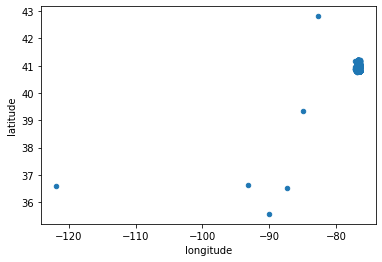

In [61]:
properties_df.plot.scatter(x='longitude',y='latitude')

In [62]:
def distance_to_math(location):
    return distance.distance(location, buckenell_math_lat_long).miles

In [63]:
properties_df['distance_to_math_dept'] = properties_df['point'].apply(distance_to_math)

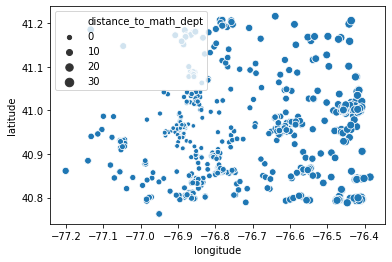

In [68]:
sns.scatterplot(data=properties_df,x='longitude',y='latitude',size='distance_to_math_dept')

In [91]:
properties_df.to_csv("properties-susquahannavalley-enriched.csv")